Data: [Bird Migration Dataset (Data Visualization / EDA)](https://www.kaggle.com/datasets/sahirmaharajj/bird-migration-dataset-data-visualization-eda) <br>
위경도 3차원 좌표계로 변환, 클러스터링

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap, FeatureGroupSubGroup
from matplotlib.pyplot import get_cmap
import matplotlib.colors as mcolors
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

In [2]:
data_path = '/hdd/data/adp_data/bird_migration_data.csv'

df = pd.read_csv(data_path, index_col = 'Bird_ID')
df.head()

,Species,Region,Habitat,Weather_Condition,Migration_Reason,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,Flight_Distance_km,...,Tracking_Quality,Migration_Interrupted,Interrupted_Reason,Tagged_By,Tag_Weight_g,Migration_Success,Recovery_Location_Known,Recovery_Time_days,Observation_Counts,Observation_Quality
Bird_ID,,,,,,,,,,,,,,,,,,,,,
B1000,Warbler,South America,Grassland,Stormy,Feeding,11.906566,-169.378251,30.377647,-21.366879,1753.79,...,Excellent,Yes,Storm,Researcher_A,27.0,Failed,No,102,56,Low
B1001,Stork,North America,Grassland,Stormy,Breeding,62.301546,-111.475069,39.921092,47.963436,3263.05,...,Good,Yes,Injury,Researcher_C,14.2,Successful,Yes,118,61,Low
B1002,Hawk,South America,Mountain,Stormy,Avoid Predators,87.861164,-78.727327,66.990980,19.448466,2871.65,...,Fair,No,Lost Signal,Researcher_B,16.1,Failed,No,41,71,High
B1003,Warbler,South America,Urban,Stormy,Climate Change,35.770590,153.104341,-49.003145,-157.868744,2317.38,...,Good,Yes,Lost Signal,Researcher_C,24.4,Successful,No,15,68,Low
B1004,Crane,Europe,Urban,Windy,Avoid Predators,-21.611614,106.674824,11.681051,-115.022863,3077.38,...,Good,No,NaN,Researcher_B,25.8,Failed,Yes,73,67,Moderate


In [3]:
def latlon_to_xyz(lat, lon, radius = 1):
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z

In [4]:
start_xyz = df[['Start_Latitude', 'Start_Longitude']].apply(
    lambda row: latlon_to_xyz(row['Start_Latitude'], row['Start_Longitude']),
    axis = 1, result_type = 'expand'
)
start_xyz.columns = ['Start_X', 'Start_Y', 'Start_Z']

end_xyz = df[['End_Latitude', 'End_Longitude']].apply(
    lambda row: latlon_to_xyz(row['End_Latitude'], row['End_Longitude']),
    axis = 1, result_type = 'expand'
)
end_xyz.columns = ['End_X', 'End_Y', 'End_Z']

xyz_df = pd.concat([start_xyz, end_xyz], axis = 1)
xyz_df.index = df.index

xyz_df.head()

,Start_X,Start_Y,Start_Z,End_X,End_Y,End_Z
Bird_ID,,,,,,
B1000,-0.961719,-0.180359,0.206316,0.803414,-0.314319,0.505697
B1001,-0.170168,-0.432549,0.885406,0.513539,0.569612,0.641732
B1002,0.007295,-0.036601,0.999303,0.368573,0.130146,0.920443
B1003,-0.723600,0.367034,0.584541,-0.607684,-0.247141,-0.754746
B1004,-0.266768,0.890607,-0.368313,-0.414220,-0.887373,0.202463


In [5]:
coords = xyz_df[['Start_X', 'Start_Y', 'Start_Z', 'End_X', 'End_Y', 'End_Z']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

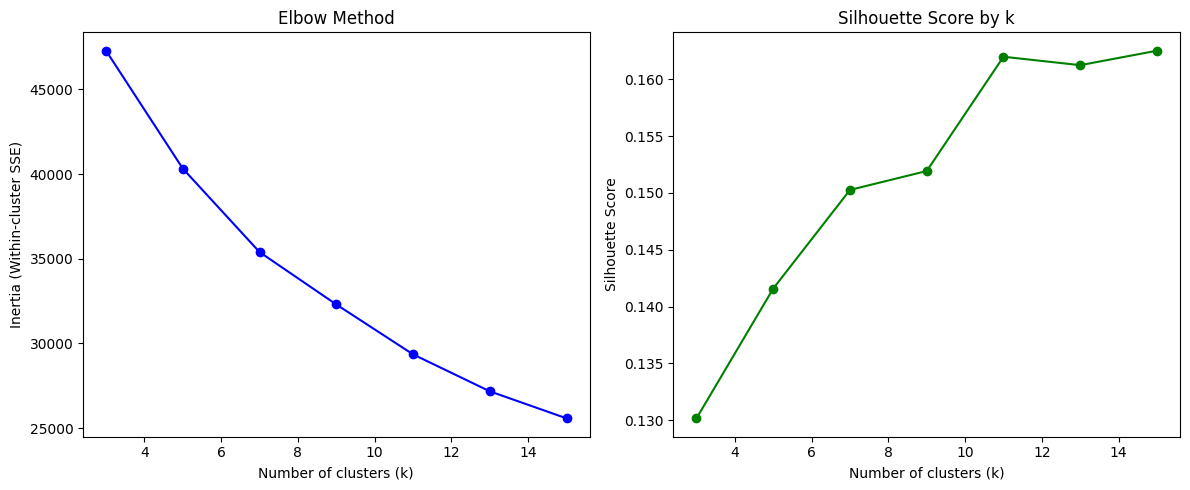

In [6]:
k_range = range(3, 16, 2)

inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 526)
    kmeans.fit(coords_scaled)

    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    score = silhouette_score(coords_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')

plt.tight_layout()
plt.show()

실루엣 점수를 기준으로 k = 11은 충분히 높은 값이고, 엘보우 그래프에서도 SSE 감소가 완만해지므로 k = 11로 결정.

In [7]:
best_k = 11

kmeans = KMeans(n_clusters = best_k, random_state = 526)
kmeans.fit(coords_scaled)

df['Cluster_KMeans'] = kmeans.labels_

In [8]:
def lighten_color(color, factor = 0.5):
    rgb = mcolors.hex2color(color)
    white = (1, 1, 1)
    lightened = tuple(white[i] + factor * (rgb[i] - white[i]) for i in range(3))
    return mcolors.to_hex(lightened)

def visualize_clusters(df, cluster_col, algorith_name):
    center_Lat = df[['Start_Latitude', 'End_Latitude']].stack().mean()
    center_Lon = df[['Start_Longitude', 'End_Longitude']].stack().mean()
    m = folium.Map(location = [center_Lat, center_Lon], zoom_start = 2)

    unique_clusters = sorted(df[cluster_col].unique())
    n_clusters = len(unique_clusters)

    color_palette = get_cmap('gist_ncar')(np.linspace(0, 1, n_clusters))
    color_palette = [mcolors.to_hex(c) for c in color_palette]
    cluster_colors = {
        -1: '#808080'
    }
    for i, cluster in enumerate(unique_clusters):
        if cluster != -1:
            cluster_colors[cluster] = color_palette[i % n_clusters]
    
    start_group = folium.FeatureGroup(
        name = f'[{algorith_name}] Start Points',
        show = True
    ).add_to(m)
    end_group = folium.FeatureGroup(
        name = f'[{algorith_name}] End Points',
        show = True
    ).add_to(m)

    for cluster in unique_clusters:
        start_sub = FeatureGroupSubGroup(
            start_group,
            name = f'Start Cluster {cluster}',
            show = True
        ).add_to(m)

        end_sub = FeatureGroupSubGroup(
            end_group,
            name = f'End Cluster {cluster}',
            show = True
        ).add_to(m)

        cluster_data = df[df[cluster_col] == cluster]

        medium_color = lighten_color(cluster_colors[cluster])
        light_color = lighten_color(medium_color)

        HeatMap(
            cluster_data[['Start_Latitude', 'Start_Longitude']].values,
            gradient = {'0.4': light_color, '0.65': medium_color, '1.0': cluster_colors[cluster]},
            radius = 8,
            blur = 10,
            name = f'Start Cluster {cluster}'
        ).add_to(start_sub)

        HeatMap(
            cluster_data[['End_Latitude', 'End_Longitude']].values,
            gradient = {'0.4': light_color, '0.65': medium_color, '1.0': cluster_colors[cluster]},
            radius = 8,
            blur = 10,
            name = f'End Cluster {cluster}'
        ).add_to(end_sub)
    
    folium.LayerControl(
        collapsed = False,
        autoZIndex = False
    ).add_to(m)

    return m

In [9]:
# kmeans_map = visualize_clusters(df, 'Cluster_KMeans', 'KMeans')
# display(kmeans_map)

위치에 따라 클러스터링이 된 것을 확인할 수 있음.

In [10]:
success_by_cluster = (
    df.groupby('Cluster_KMeans')['Migration_Success'].value_counts(normalize = True).unstack()
)

print(success_by_cluster)

Migration_Success    Failed  Successful
Cluster_KMeans                         
0                  0.478027    0.521973
1                  0.491741    0.508259
2                  0.525460    0.474540
3                  0.468750    0.531250
4                  0.483912    0.516088
5                  0.510336    0.489664
6                  0.464467    0.535533
7                  0.464377    0.535623
8                  0.506092    0.493908
9                  0.507477    0.492523
10                 0.492121    0.507879


시작위치와 종료위치에 따른 성공률의 차이는 크게 없는 것같음.

In [11]:
def plot_k_distance(X, k = 5):
    neigh = NearestNeighbors(n_neighbors = k + 1)
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)

    k_distances = np.sort(distances[:, k])

    plt.figure(figsize = (10, 4))
    plt.plot(k_distances)
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.xlabel('Points sorted by distance')
    plt.title(f'k-distance plot (k = {k}) for DBSCAN eps selection')
    plt.grid()
    plt.show()

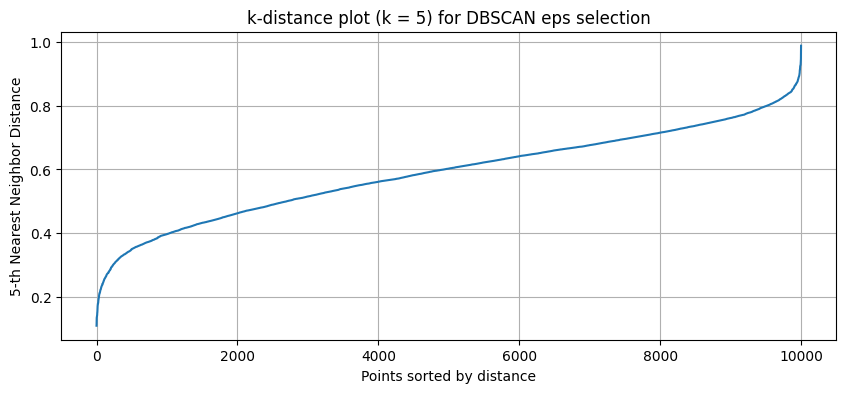

In [12]:
plot_k_distance(coords_scaled)

In [13]:
min_sample_candidates = range(6, 15)
eps = 0.8

for min_samples in min_sample_candidates:
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    labels = dbscan.fit_predict(coords_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        score = silhouette_score(coords_scaled, labels)
        score_str = f'{score:.4f}'
    else:
        score_str = 'N/A'
    
    print(f"min_samples = {min_samples} -> clusters = {n_clusters}, silhouette_score = {score_str}")

min_samples = 6 -> clusters = 1, silhouette_score = N/A
min_samples = 7 -> clusters = 1, silhouette_score = N/A
min_samples = 8 -> clusters = 2, silhouette_score = -0.0527
min_samples = 9 -> clusters = 5, silhouette_score = -0.1720
min_samples = 10 -> clusters = 13, silhouette_score = -0.3121
min_samples = 11 -> clusters = 10, silhouette_score = -0.2887
min_samples = 12 -> clusters = 18, silhouette_score = -0.3459
min_samples = 13 -> clusters = 14, silhouette_score = -0.3168
min_samples = 14 -> clusters = 7, silhouette_score = -0.2240


In [14]:
eps_candidates = np.arange(0.5, 1.5, 0.1)

for eps in eps_candidates:
    dbscan = DBSCAN(eps = eps, min_samples = 8)
    labels = dbscan.fit_predict(coords_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        score = silhouette_score(coords_scaled, labels)
        score_str = f'{score:.4f}'
    else:
        score_str = 'N/A'
    
    print(f"eps = {eps:.2f} -> clusters = {n_clusters}, silhouette_score = {score_str}")

eps = 0.50 -> clusters = 32, silhouette_score = -0.4703
eps = 0.60 -> clusters = 45, silhouette_score = -0.4880
eps = 0.70 -> clusters = 42, silhouette_score = -0.4176
eps = 0.80 -> clusters = 2, silhouette_score = -0.0527
eps = 0.90 -> clusters = 1, silhouette_score = N/A
eps = 1.00 -> clusters = 1, silhouette_score = N/A
eps = 1.10 -> clusters = 1, silhouette_score = N/A
eps = 1.20 -> clusters = 1, silhouette_score = N/A
eps = 1.30 -> clusters = 1, silhouette_score = N/A
eps = 1.40 -> clusters = 1, silhouette_score = N/A


In [15]:
dbscan = DBSCAN(eps = 0.8, min_samples = 8)
labels = dbscan.fit_predict(coords_scaled)

df['Cluster_DBSCAN'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
if n_clusters > 1:
    score = silhouette_score(coords_scaled, labels)
    print(f'Silhouette Score: {score:.4f}')
else:
    print('클러스터가 2개 이상이 아니므로 실루엣 점수 계산 불가')

Silhouette Score: -0.0527


In [16]:
# kmeans_map = visualize_clusters(df, 'Cluster_DBSCAN', 'DBSCAN')
# display(kmeans_map)

In [17]:
success_by_cluster = (
    df.groupby('Cluster_DBSCAN')['Migration_Success'].value_counts(normalize = True).unstack()
)

print(success_by_cluster)

Migration_Success    Failed  Successful
Cluster_DBSCAN                         
-1                 0.560000    0.440000
 0                 0.490024    0.509976
 1                 1.000000         NaN


DBSCAN 결과, 대부분의 데이터가 하나의 클러스터(0번)로 묶이며 전역적으로 분포하고 있어, 이 데이터에서는 위치 기반의 밀도 차이가 뚜렷하지 않아 명확한 군집 구조를 찾기 어렵다.

/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


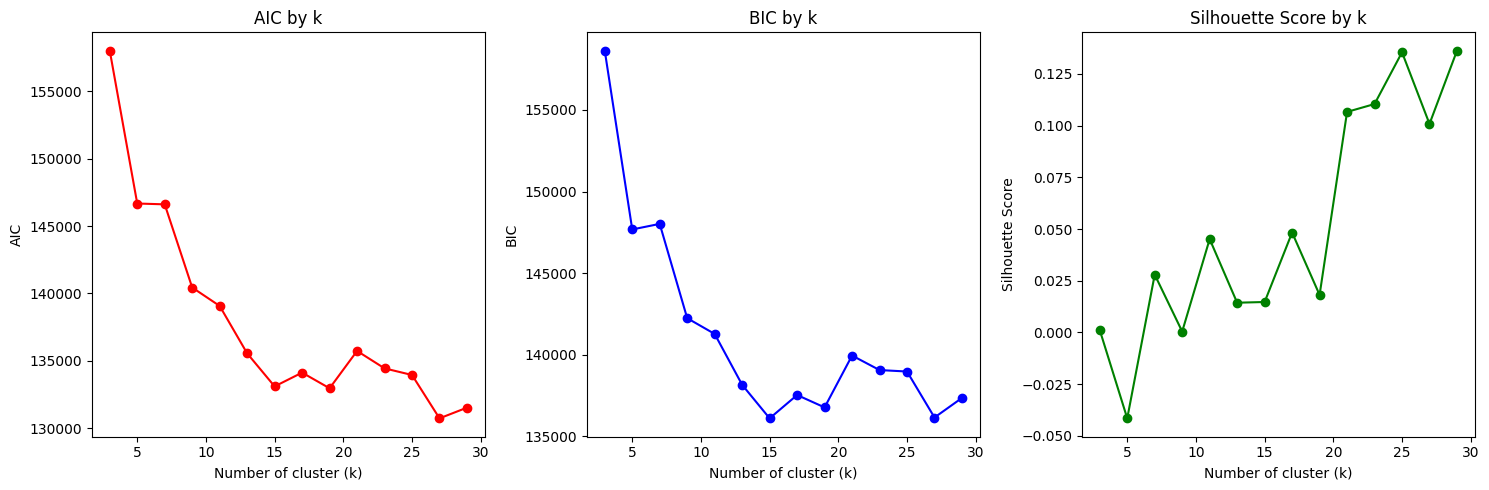

In [18]:
k_range = range(3, 30, 2)

aic_scores = []
bic_scores = []
silhouette_scores = []

for k in k_range:
    gmm = GaussianMixture(n_components = k, random_state = 526)
    labels = gmm.fit_predict(coords_scaled)
    
    aic_scores.append(gmm.aic(coords_scaled))
    bic_scores.append(gmm.bic(coords_scaled))

    if len(set(labels)) > 1:
        score = silhouette_score(coords_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores.append(score)

plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, aic_scores, 'ro-')
plt.xlabel('Number of cluster (k)')
plt.ylabel('AIC')
plt.title('AIC by k')

plt.subplot(1, 3, 2)
plt.plot(k_range, bic_scores, 'bo-')
plt.xlabel('Number of cluster (k)')
plt.ylabel('BIC')
plt.title('BIC by k')

plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')

plt.tight_layout()
plt.show()

In [19]:
gmm = GaussianMixture(n_components = 25, random_state = 526)
labels = gmm.fit_predict(coords_scaled)

df['Cluster_GMM'] = labels

In [20]:
# # matplotlib의 컬러맵 tab20은 20가지 색상만 지원해서 25개의 클러스터는 그릴 수 없음. tab20 -> gist_ncar로 수정해서 돌리면
# kmeans_map = visualize_clusters(df, 'Cluster_GMM', 'GMM')
# display(kmeans_map)

In [21]:
success_by_cluster = (
    df.groupby('Cluster_GMM')['Migration_Success'].value_counts(normalize = True).unstack()
)

print(success_by_cluster)

Migration_Success    Failed  Successful
Cluster_GMM                            
0                  0.434903    0.565097
1                  0.500000    0.500000
2                  0.473354    0.526646
3                  0.474201    0.525799
4                  0.515504    0.484496
5                  0.497382    0.502618
6                  0.541254    0.458746
7                  0.495816    0.504184
8                  0.493827    0.506173
9                  0.477327    0.522673
10                 0.452290    0.547710
11                 0.502463    0.497537
12                 0.508772    0.491228
13                 0.517094    0.482906
14                 0.488263    0.511737
15                 0.475059    0.524941
16                 0.485255    0.514745
17                 0.480100    0.519900
18                 0.518919    0.481081
19                 0.510417    0.489583
20                 0.476378    0.523622
21                 0.528736    0.471264
22                 0.479381    0.520619


Start_Latitude, Start_Longitude, End_Latitude, End_Longitude를 이용해서 3차원 데이터로 변환하고, k-means, DBSCAN, GMM 클러스터링 기법을 적용했다. 클러스터 간 명확한 경계나 이동 성공률의 유의미한 차이는 확인되지 않았다.<br>
다만 DBSCAN에서 클러스터 1로 분류된 데이터는 이동 성공률이 0%로, 이동 실패가 집중되는 양상을 보였다. 이동 성공 여부에 영향을 미치는 요인을 더 구체적으로 파악하기 위해서는 지도학습 기반의 분류 모델을 활용하는 것이 더 적합할 것으로 보인다.